# CF$_3$ + F IRC tutorial

This tutorial walks through core IRC analyses for the CF$_3$ + F reaction. It focuses on energetic and conceptual DFT properties plus a few key geometric descriptors along the reaction coordinate. File I/O and advanced customization are intentionally omitted to keep the workflow concise.

In [14]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
from kudi import IRCPath


def find_repo_root(start: Path | None = None) -> Path:
    here = (start or Path.cwd()).resolve()
    for parent in [here, *here.parents]:
        if (parent / "pyproject.toml").exists():
            return parent
    raise FileNotFoundError("Could not find repo root containing pyproject.toml")


repo_root = find_repo_root()
sys.path.insert(0, str(repo_root / "src"))
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True


def geometry_to_array(geometry):
    return np.array([[atom.x, atom.y, atom.z] for atom in geometry.atoms], dtype=float)


def bond_distance(geom, i, j):
    coords = geometry_to_array(geom)
    return float(np.linalg.norm(coords[i] - coords[j]))


def bond_angle(geom, i, j, k):
    coords = geometry_to_array(geom)
    v1 = coords[i] - coords[j]
    v2 = coords[k] - coords[j]
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return np.nan
    cos_theta = np.clip(np.dot(v1, v2) / (norm1 * norm2), -1.0, 1.0)
    return float(np.degrees(np.arccos(cos_theta)))


In [15]:
data_path = repo_root / "tests" / "fixtures" / "cf3+f.dat"
irc_path = IRCPath.from_file(data_path)
rx = np.asarray(irc_path.rx_coords, dtype=float)
print(f"Loaded {len(irc_path.points)} IRC points from {data_path}")
first_geom = next((g for g in irc_path.geometries if g is not None), None)
atom_map = [(idx + 1, atom.symbol) for idx, atom in enumerate(first_geom.atoms)] if first_geom else []
print("Atom index map (1-based):", atom_map)


Loaded 85 IRC points from /home/svogt/repos/kudi/tests/fixtures/cf3+f.dat
Atom index map (1-based): [(1, 'C'), (2, 'H'), (3, 'H'), (4, 'H'), (5, 'F'), (6, 'F')]


In [16]:
energy_kcal = np.asarray(irc_path.relative_energies_kcal(), dtype=float)
force_data = irc_path.reaction_force()
mu_data = irc_path.chemical_potential_koopmans()
flux_data = irc_path.flux()


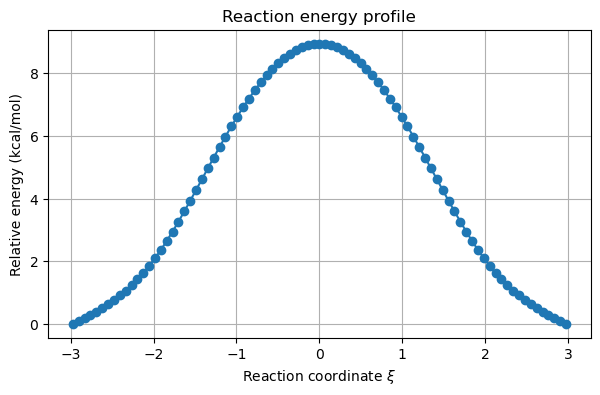

In [17]:
fig, ax = plt.subplots()
ax.plot(rx, energy_kcal, marker="o")
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel("Relative energy (kcal/mol)")
ax.set_title("Reaction energy profile")
plt.show()


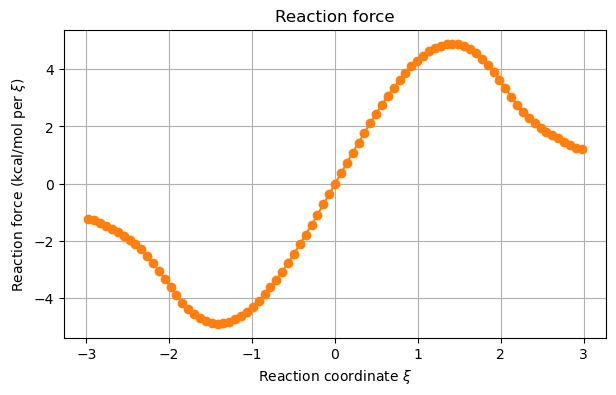

In [24]:
fig, ax = plt.subplots()
ax.plot(force_data["reaction_coordinate"], force_data["reaction_force"], marker="o", color="C1")
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel(r"Reaction force (kcal/mol per $\\xi$)")
ax.set_title("Reaction force")
plt.show()


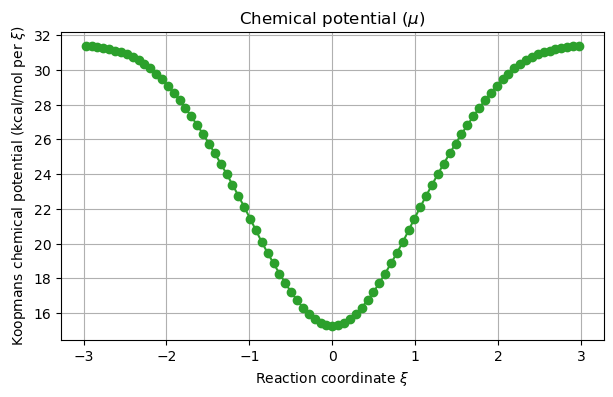

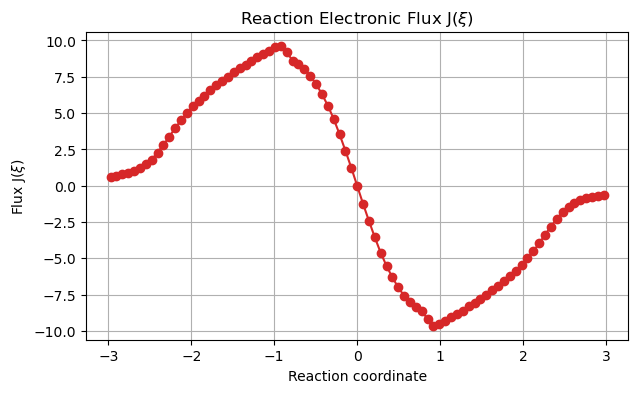

In [32]:
fig, ax = plt.subplots()
ax.plot(mu_data["reaction_coordinate"], mu_data["chemical_potential"], marker="o", color="C2")
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel(r"Koopmans chemical potential (kcal/mol per $\xi$)")
ax.set_title(r"Chemical potential ($\mu$)")
plt.show()

fig, ax = plt.subplots()
ax.plot(flux_data["reaction_coordinate"], flux_data["flux"], marker="o", color="C3")
ax.set_xlabel(r"Reaction coordinate")
ax.set_ylabel(r"Flux J($\xi$)")
ax.set_title(r"Reaction Electronic Flux J($\xi$)")
plt.show()


### Bond distances along the IRC

We focus on the forming C–F bond. Indices follow the map printed above.

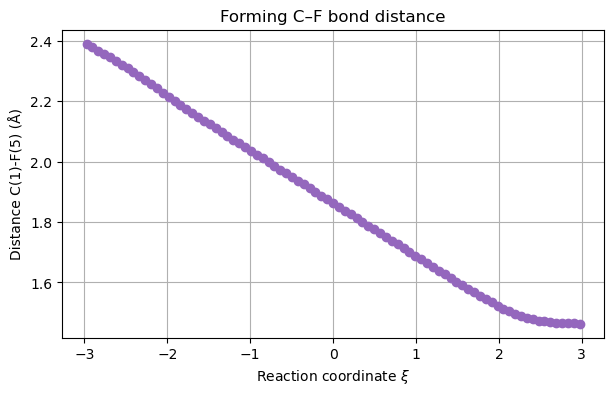

In [33]:
c_idx, f_in_idx = 0, 4  # zero-based for C(1) and F(5)
distances = []
for geom in irc_path.geometries:
    if geom is None:
        distances.append(np.nan)
        continue
    distances.append(bond_distance(geom, c_idx, f_in_idx))
distances = np.asarray(distances, dtype=float)

fig, ax = plt.subplots()
ax.plot(rx, distances, marker="o", color="C4")
ax.set_xlabel(r"Reaction coordinate $\xi$")
ax.set_ylabel("Distance C(1)-F(5) (Å)")
ax.set_title("Forming C–F bond distance")
plt.show()


### Interpretation notes

* The reaction energy highlights the barrier and asymptotic products in kcal/mol.
* The reaction force pinpoints where structural rearrangements accelerate (negative) or decelerate (positive) along $\xi$.
* Koopmans chemical potential and its flux trace frontier-orbital responses; flux extrema often align with bonding changes.
* C–F distance  contextualize how the incoming fluorine approaches and reorganizes the carbon center.